# Randomized Benchmarking: Basic Tutorial

This tutorial demonstrates how to perform randomized benchmarking (RB) using `pygsti`.  While RB is a very distinct protocol from Gate Set Tomography (GST), `pygsti` includes basic support for RB because of its prevalence in the community, its simplicity, and its considerable use of GST-related concepts and data structures. The core protocol is standard Clifford randomized benchmarking defined in ["Scalable and Robust Benchmarking of Quantum Processes"](http://journals.aps.org/prl/abstract/10.1103/PhysRevLett.106.180504). Much of the notation is consistent with Wallman and Flammia's ["Randomized benchmarking with confidence"](http://iopscience.iop.org/article/10.1088/1367-2630/16/10/103032).

This tutorial will show the following, all in the context of benchmarking a single qubit:
- How to create a list of random RB sequences (experiments).  These are just a list of pyGSTi `GateString` objects.
- How to write a template data file from this list.
- How to compute RB fit parameters from a pyGSTi `DataSet` filled with RB sequence data.
- How to compute error bars on the various RB parameters and derived quantities.

We'll begin by importing relevant modules:

In [1]:
from __future__ import print_function #python 2 & 3 compatibility

import pygsti
from pygsti.extras import rb
from pygsti.construction import std1Q_XYI

%matplotlib inline

Fully specified RPE configuration.


## Primitive gates, and how they map to Cliffords
First, let's choose a "target" gateset.  This is the set of physically-implemented, or "primitive" gates.  For this tutorial, we'll just use the standard $I$, $X(\pi/2)$, $Y(\pi/2)$ set. The target gateset should generate the Clifford group (or some other unitary 2-design).

In [2]:
gs_target = std1Q_XYI.gs_target
print("Primitive gates = ", gs_target.gates.keys())

Primitive gates =  [u'Gi', u'Gx', u'Gy']


To generate appropriately random RB sequences, we'll need to know how the set of all the Clifford gates map onto the given primitive set (since RB requires sequences to be random sequences of *Cliffords*, not of primitive gates).  PyGSTi already contains the group of 1-qubit Cliffords. Benchmarking of a different group, or the $n>1$ qubit Clifford group requires the user to define this group.

PyGSTi contains a standard compilation of each 1-qubit Clifford in terms of a set of seven "canonical" Clifford gates, $\{I,X(\pi/2),X(\pi),X(-\pi/2),Y(\pi/2),Y(\pi),Y(-\pi/2)\}$. Thus, we only need to know how to express each of these canonical gates as our primitive gates; then we can compose the mappings: {all Cliffords} $\rightarrow$ {canonical Cliffords} and {canonical Cliffords} $\rightarrow$ {primitive gates} to get our desired {all Cliffords} $\rightarrow$ {primitive gates} map.

In [3]:
# get the all-Cliffords --> canonical-Cliffords map
clifford_to_canonical = rb.std1Q.clifford_to_canonical

# define the canonical-Cliffords --> primitive-gates map
canonical_to_primitive = { 'Gi':['Gi'],
            'Gxp2':['Gx'], 'Gxp':['Gx','Gx'], 'Gxmp2':['Gx','Gx','Gx'],
            'Gyp2':['Gy'], 'Gyp':['Gy','Gy'], 'Gymp2':['Gy','Gy','Gy'] }

#Compose the two maps above to get the all-Cliffords --> primitive-gates map
clifford_to_primitive = pygsti.construction.compose_alias_dicts(
                            clifford_to_canonical,canonical_to_primitive)

Alternatively, for the primitive gateset $I$, $X(\pi/2)$, $Y(\pi/2)$, pyGSTi contains this particular compilation of each clifford directly into these primitive gates as a dictionary:

In [4]:
clifford_to_primitive = rb.std1Q.clifford_to_XYI

# get the 1Q Clifford group: the canonical set of superoperator matrices representing the Clifford group, used later.
clifford_group = rb.std1Q.clifford_group

## Generating RB sequences
Now let's decide what random Clifford sequences to generate.  We use $m$ to denote the length of a Clifford sequence, in Clifford gates and *not* including the inversion Clifford at the end of each sequence. $K_m$ denotes the number of different random sequences of length $m$ to use. Note: `K_m_sched` need not be $m$-independent, and can be a dictionary, with $(m,K_m)$ key-value pairs.  We'll demo this in a later tutorial.

In [5]:
m_min = 1        # minimum Clifford sequence length
m_max = 1000     # maximum Clifford sequence length
delta_m = 100    # length step size 
K_m_sched = 10   # K_m == 10 (constant) for all m

Now we generate the list of random RB Clifford sequences to run.  The `write_empty_rb_files` function handles this job, and does a lot. Here's what this one function call does:

- It creates lists of random RB gate sequences, one list for each $m$, according to the schedule given by $m_{min}$, $m_{max}$, $\delta_m$, and $K_m$.  These sequences are expressed as strings of Clifford gate labels and translated using any of the supplied maps (in this case, the string are translated to "primitive" labels also).  These lists-of-lists are returned as a dictionary whose keys are "clifford" (always present) and "primitive" (b/c it's a key of the dict passed as `alias_maps`).
- The lists for each set of gate labels (the Cliffords and primitives in this case) is aggregated across all $m$ values (so there's just a single list of all the RB sequences) and saved to a file beginning with the given base filename.
- An empty `DataSet` is saved in text format using the RB sequences expressed in terms of Clifford gates.


In [6]:
filename_base = 'tutorial_files/rb_template'
rb_sequences = rb.write_empty_rb_files(filename_base, m_min, m_max, delta_m,
                                       clifford_group, K_m_sched,
                                       {'primitive': clifford_to_primitive},
                                       seed=0)

There is now an empty template file [tutorial_files/rb_template.txt](tutorial_files/rb_template.txt). For actual physical experiments, this file should be filled with experimental data and read in using `pygsti.io.load_dataset`.  In this tutorial, we will generate fake data instead and just use the resulting dataset object.

The files [tutorial_files/rb_template_clifford.txt](tutorial_files/rb_template_clifford.txt) and [tutorial_files/rb_template_primitive.txt](tutorial_files/rb_template_primitive.txt) are text files listing all the RB sequences, expressed in terms of Cliffords and primitives respectively.

## Generating fake data

To generate a dataset, we first need to make a gateset. Here we assume a gate set that is perfect except for some small amount of depolarizing noise on each primitive gate.

In [7]:
depol_strength = 1e-3
gs_experimental = std1Q_XYI.gs_target
gs_experimental = gs_experimental.depolarize(gate_noise=depol_strength)

Now we choose the number of clicks per experiment and simulate our data. More information on simulating RB can be found in the following tutorial.

In [8]:
all_rb_sequences = [] #construct an aggregate list of Clifford sequences
for seqs_for_single_cliff_len in rb_sequences['clifford']:
    all_rb_sequences.extend(seqs_for_single_cliff_len)
    
N=100 # number of samples
rb_data = pygsti.construction.generate_fake_data(
    gs_experimental,all_rb_sequences,N,'binomial',seed=1,
    aliasDict=clifford_to_primitive, collisionAction="keepseparate")

## Running the RB analysis
Now that we have data, it's time to perform the RB analysis.  The 
function `do_randomized_benchmarking` returns an `RBResults` object which holds all the relevant input and output RB quantities.  This object can be used to generate error bars on the computed RB quanties.

Some important arguments are:
- success_spamlabel : the spam label corresponding to the *expected* outcome when preparing and immediately measuring.
- dim : the Hilbert space dimension.  This defaults to 2 (the 1-qubit case) and so can usually be left out.

In [9]:
rb_results = rb.do_randomized_benchmarking(rb_data, all_rb_sequences,success_spamlabel='minus', dim=2)

## Examining the output

Okay, so we've done RB!  Now let's examine how we can use the returned `RBResults` object to visualize and inspect the results.  First let's plot the averaged RB data (i.e., averaged over sequences at each length) and the decay curve that has been fit to the data.

Some useful optional arguments are: xlim, ylim, save_fig_path, loc, which all perform the standard matploblib functions, and also legend (true or false), title (true or false).

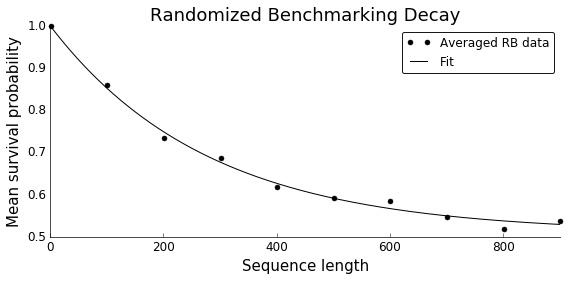

In [10]:
rb_results.plot()

Let's look at the RB fit results.  The parameters are defined as follows,
following the Wallman and Flammia article cited above.
- `A`,`B`,`f` are fit parameters to the standard RB fitting function $P_m = A+B\,f^m$, where $P_m$ is the average "survival probability" for sequences of length $m$.
- `r` $= (1-p)(d-1)/d$.  This is the the "RB number".
- To express the RB result as a "fidelity"-like quantity, rather than an error rate, we can consider $1-r$.

In [11]:
rb_results.print_clifford()

RB results

  - Fitting to the standard function: A + B*f^m.

A = 0.509876520458
B = 0.490123479542
f = 0.996421673113
r = 0.00178916344348



## Error Bars
Lastly, let's put some error bars on the estimates. There are two methods for computing the error bars: analytic error bars using the method of Wallman and Flammia in ["Randomized benchmarking with confidence"](http://iopscience.iop.org/article/10.1088/1367-2630/16/10/103032), or bootstrapped error bars. Error bars here are 1-sigma confidence intervals. The Wallman and Flammia method is only possible with a particular $K_m$ schedule, and they cannot be calculated with a constant $K_m$, as here. So, we compute bootstrapped error bars:

In [12]:
rb_results.compute_bootstrap_error_bars(seed=0)

Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-param

Now that we've generated (bootstrapped) error bars, we can print them using the same print methods as before:

In [13]:
rb_results.print_clifford()

RB results

  - Fitting to the standard function: A + B*f^m.
  - Boostrapped-derived error bars (1 sigma).

A = 0.509876520458 +/- 0.0135577554088
B = 0.490123479542 +/- 0.0130134157644
f = 0.996421673113 +/- 0.000304623218075
r = 0.00178916344348 +/- 0.000152311609037



We can also manually extract the error bars, and other results parameters. For example:

In [14]:
print(rb_results.dicts['clifford']['r'])
print(rb_results.dicts['clifford']['r_error_BS'])

0.00178916344348
0.000152311609037
